In [ ]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [ ]:
import cv2

In [ ]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 50
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "/content/drive/MyDrive/Potato_Leaves_Dataset"
# /content/drive/MyDrive/Potato_Disease_Predict.ipynb
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = ds.cardinality().numpy()

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

3 ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


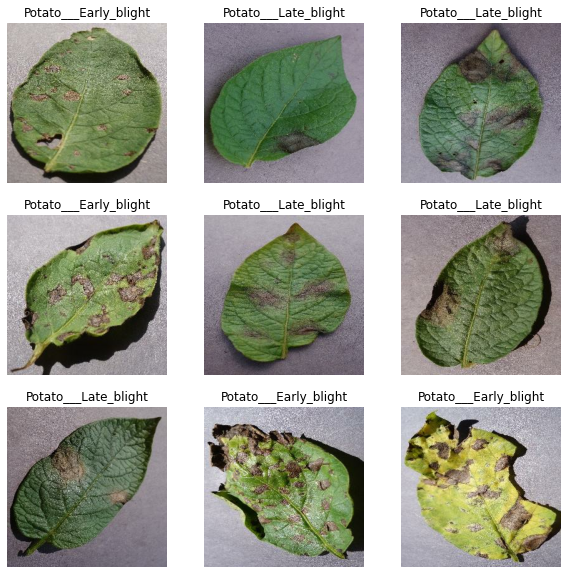

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 256, 256, 3)
(8,)


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

In [ ]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

**Training the Network**

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
54/54 [==============================] - 224s 4s/step - loss: 0.8879 - accuracy: 0.4982 - val_loss: 0.7946 - val_accuracy: 0.6510
Epoch 2/50
54/54 [==============================] - 203s 4s/step - loss: 0.6744 - accuracy: 0.6860 - val_loss: 0.5064 - val_accuracy: 0.8021
Epoch 3/50
54/54 [==============================] - 204s 4s/step - loss: 0.4735 - accuracy: 0.7999 - val_loss: 0.3412 - val_accuracy: 0.8802
Epoch 4/50
54/54 [==============================] - 201s 4s/step - loss: 0.3311 - accuracy: 0.8633 - val_loss: 0.3669 - val_accuracy: 0.8438
Epoch 5/50
54/54 [==============================] - 201s 4s/step - loss: 0.2499 - accuracy: 0.9020 - val_loss: 0.2876 - val_accuracy: 0.8646
Epoch 6/50
54/54 [==============================] - 201s 4s/step - loss: 0.2057 - accuracy: 0.9249 - val_loss: 0.1627 - val_accuracy: 0.9531
Epoch 7/50
54/54 [==============================] - 203s 4s/step - loss: 0.2213 - accuracy: 0.9114 - val_loss: 0.3030 - val_accuracy: 0.8854
Epoch 8/50
54

**Testing the Model**

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
8/8 [==============================] - 16s 923ms/step - loss: 0.2013 - accuracy: 0.9414
Test Accuracy: 94.14%


**Plotting the Accuracy and Loss Curves**

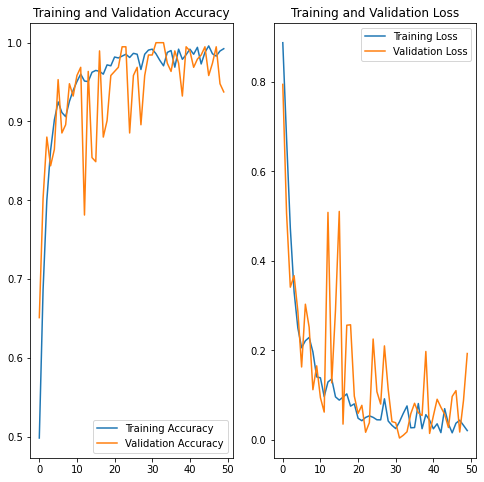

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import os
# model_version = os.listdir("/content/drive/MyDrive/Potato_Disease_Codes")
model.save(f"/content/drive/MyDrive/Potato_Disease_Codes/potato_model.h5")
# /content/drive/MyDrive/Potato_Disease_Codes

In [ ]:
model_saved = tf.keras.models.load_model("/content/drive/MyDrive/Potato_Disease_Codes/potato_model.h5")
# /content/drive/MyDrive/Potato_Disease_Codes
# /content/drive/MyDrive/Potato_Disease_Codes/['Potato_Disease_Predict-1.ipynb']

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    # img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model_saved.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

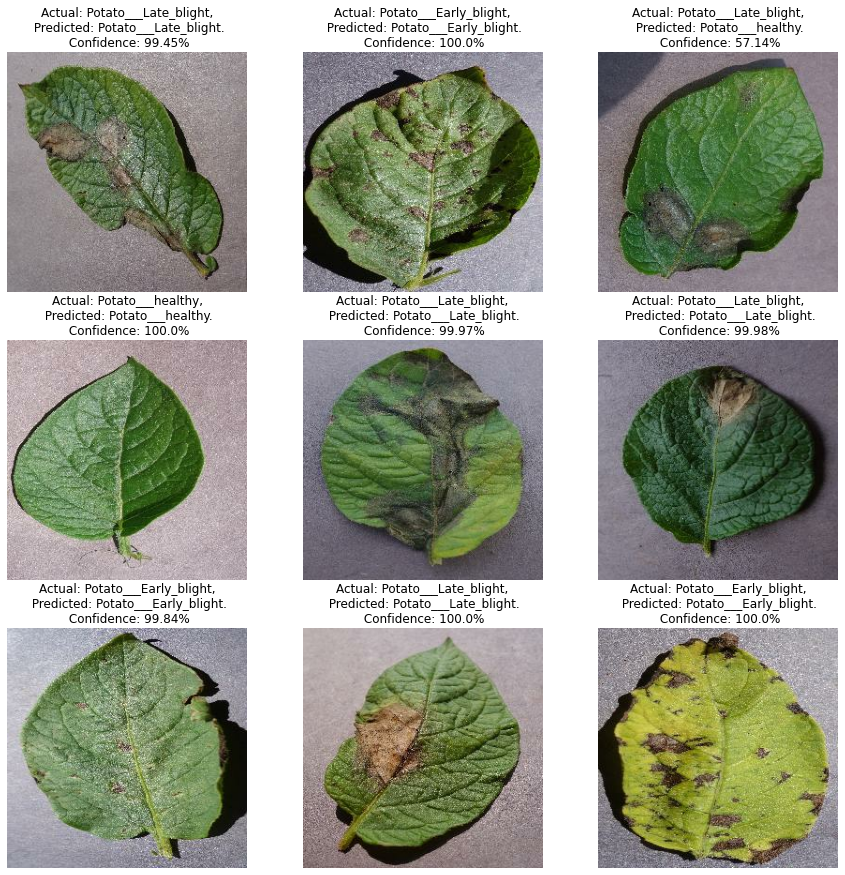

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model,images[i].numpy())      # images[i].numpy())

        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [ ]:
from PIL import Image

In [ ]:
# image='/content/drive/MyDrive/TestImage_Potatoes/test_img1.JPG'
image='/content/drive/MyDrive/TestImage_Potatoes/test_img2.JPG'
image = np.array(
    Image.open(image).resize((256, 256)) # image resizing
)

image = image/255 # normalize the image in 0 to 1 range
img_array = tf.keras.preprocessing.image.img_to_array(image)
img_array = tf.expand_dims(img_array, 0)
predictions = model_saved.predict(img_array)

print("Predictions:",predictions)
pred_class = class_names[np.argmax(predictions)]
conf = round(100 * (np.max(predictions)), 2)

print("Predicted Potato Class: ",pred_class)
print("Confidence: ",conf)

Predictions: [[0.7123873  0.2858592  0.00175347]]
Predicted Potato Class:  Potato___Early_blight
Confidence:  71.24


first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight
confidence: 99.45


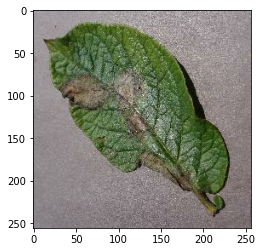

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model_saved.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    print("confidence:",round(100 * (np.max(batch_prediction[0])), 2))